# Titanic - Machine Learning from Disaster

### Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from pycaret.datasets import get_data
from pycaret.classification import *

### Load Data

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [75]:
test.head(2)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,FamilyOnBoard,Title
0,892,3,male,34.5,7.8292,Q,0,Mr.
1,893,3,female,47.0,7.0000,S,1,Mrs.


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Data Wrangling

#### Handling Missing Data

In [14]:
train.isnull().sum().sort_values(ascending=False)/len(train)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

In [15]:
test.isnull().sum().sort_values(ascending=False)/len(test)

Cabin          0.782297
Age            0.205742
Fare           0.002392
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Embarked       0.000000
dtype: float64

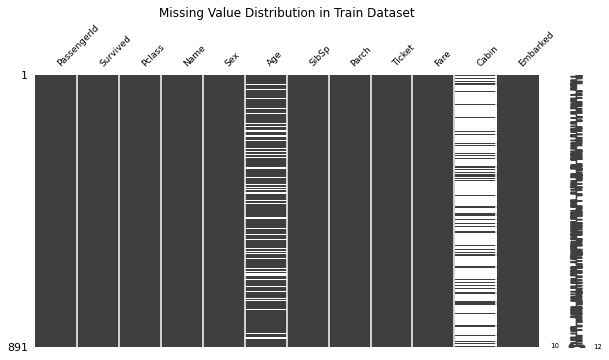

In [16]:
missingno.matrix(train,figsize=(10,5), fontsize=9)
plt.title("Missing Value Distribution in Train Dataset");

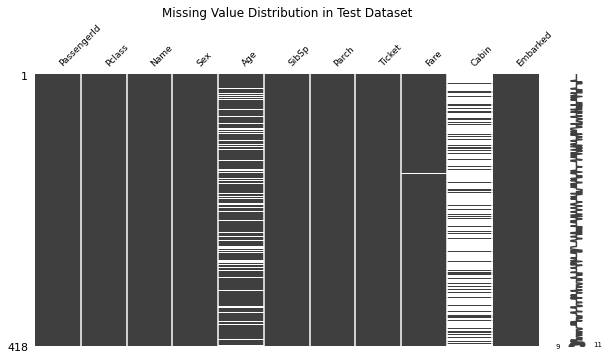

In [17]:
missingno.matrix(test,figsize=(10,5), fontsize=9)
plt.title("Missing Value Distribution in Test Dataset");

There are more than 75% missing data in Cabin column and will be difficult to generalize with this for the entire set of observations. I will b dropping the column outrightly. Age of perssengers has about 20% missing data and fare paid has a few missing values. Missing values in Age and Fare will be filled while processing the data using a wrangle function defined below.

#### Identify Outliers

We can see some outliers in based on the boxplots and histograms below. I will set an outlier threshold when define the model.

In [18]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


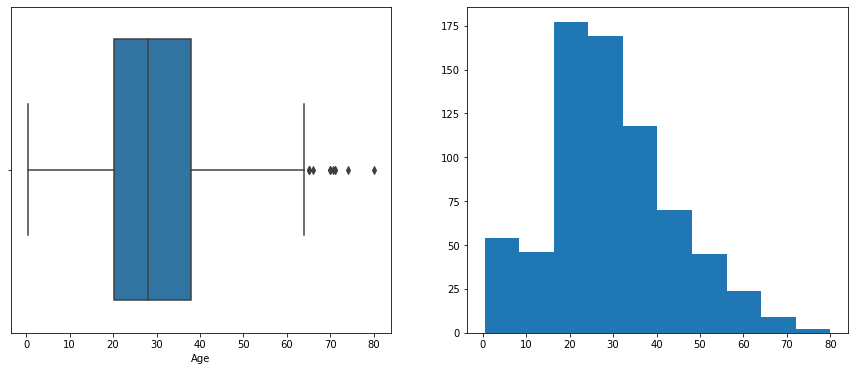

In [19]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["Age"], ax=ax[0])
plt.hist(train["Age"]);

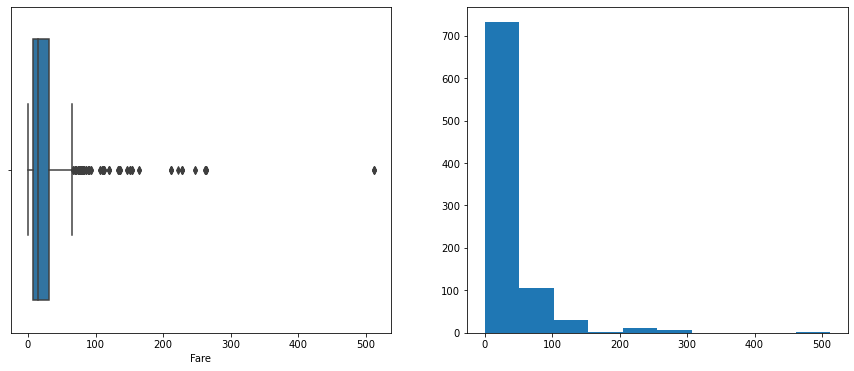

In [20]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x= train["Fare"], ax=ax[0])
plt.hist(train["Fare"]);

#### Identify Features with High Cardinality and Multicolinearity

In [21]:
train.select_dtypes("object").nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

Name and Ticket features presented to have high cardinality and should be dropped. Though they will be analyzed further to check if anything can be extracted from them

Title column is then extracted from the Name to see if the title of a passenger has any influence in the survival rate.

In [22]:
train.select_dtypes("number").nunique()

PassengerId    891
Survived         2
Pclass           3
Age             88
SibSp            7
Parch            7
Fare           248
dtype: int64

In [ ]:
It looks like grouping passengers traveling with friends and family may have some factors in survival of passengers. FamilyOnBoard column is created by merging Parch and SibSp columns.

In [23]:
correlation = train.select_dtypes("number").corr()
correlation

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


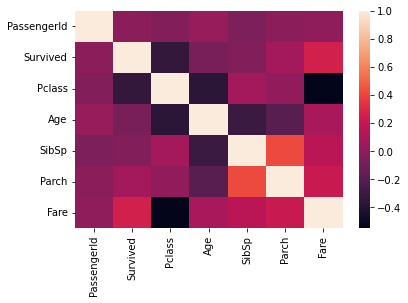

In [24]:
sns.heatmap(correlation);

In [25]:
def wrangle(filepath):
    # Read csv file into dataFrame
    df = pd.read_csv(filepath)
    
    # Fill missing data
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0])
    df.drop(columns="Cabin",inplace=True)    
    
    # Create a FamilyOnBoard column from SibSp and Parch
    df["FamilyOnBoard"] = df["SibSp"] + df["Parch"]
    df.drop(columns=["SibSp","Parch"],inplace=True)
    
    # Create Title column from Name
    df["Title"] = df["Name"].str.split(" ",expand=True)[1]
    
    
    # Drop multicolinearity column
    
    # Drop columns with high cardinality
    df.drop(columns=["Name","Ticket"],inplace=True)
    
    return df

In [85]:
data = wrangle("train.csv")
data.head(50)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyOnBoard,Title
0,1,0,3,male,22.000000,7.2500,S,1,Mr.
1,2,1,1,female,38.000000,71.2833,C,1,Mrs.
2,3,1,3,female,26.000000,7.9250,S,0,Miss.
3,4,1,1,female,35.000000,53.1000,S,1,Mrs.
4,5,0,3,male,35.000000,8.0500,S,0,Mr.
5,6,0,3,male,29.699118,8.4583,Q,0,Mr.
6,7,0,1,male,54.000000,51.8625,S,0,Mr.
7,8,0,3,male,2.000000,21.0750,S,4,Master.
8,9,1,3,female,27.000000,11.1333,S,2,Mrs.
9,10,1,2,female,14.000000,30.0708,C,1,Mrs.


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Sex            891 non-null    object 
 4   Age            891 non-null    float64
 5   Fare           891 non-null    float64
 6   Embarked       889 non-null    object 
 7   FamilyOnBoard  891 non-null    int64  
 8   Title          891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [28]:
data.drop(columns="PassengerId",inplace=True)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Sex            891 non-null    object 
 3   Age            891 non-null    float64
 4   Fare           891 non-null    float64
 5   Embarked       889 non-null    object 
 6   FamilyOnBoard  891 non-null    int64  
 7   Title          891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


### Data Exploration

In [89]:
# Explore Relationships between Categorical Features

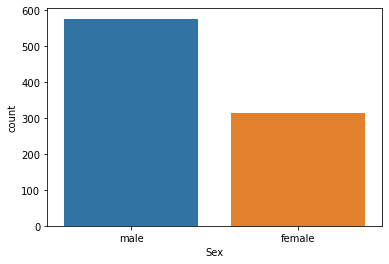

In [30]:
sns.countplot(data= data, x="Sex");

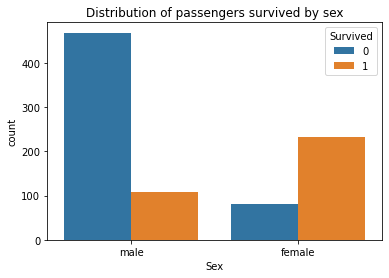

In [31]:
sns.countplot(hue="Survived", x="Sex", data=data)
plt.title('Distribution of passengers survived by sex');

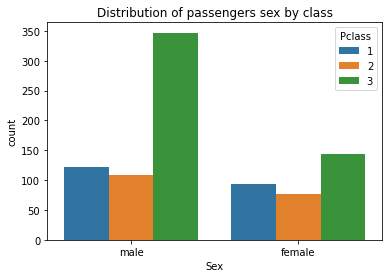

In [32]:
sns.countplot(hue="Pclass", x="Sex", data=data)
plt.title('Distribution of passengers sex by class');

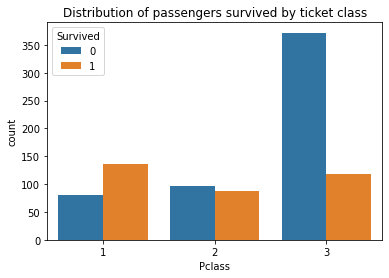

In [33]:
sns.countplot(hue="Survived", x="Pclass", data=data)
plt.title('Distribution of passengers survived by ticket class');

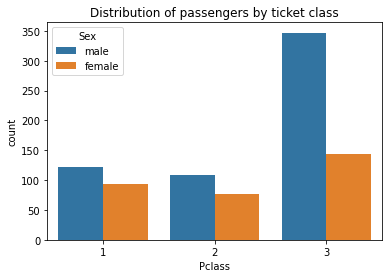

In [34]:
sns.countplot(hue="Sex", x="Pclass", data=data)
plt.title('Distribution of passengers by ticket class');

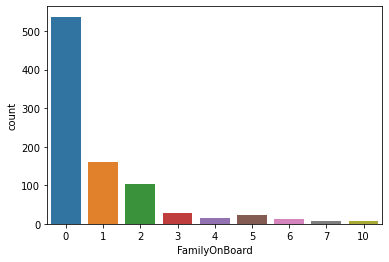

In [35]:
sns.countplot(data= data, x="FamilyOnBoard");

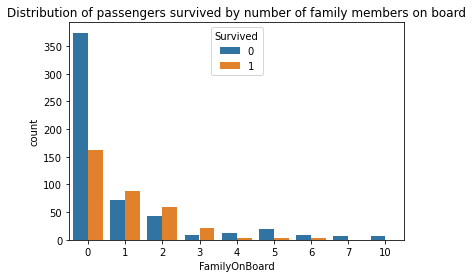

In [36]:
sns.countplot(hue="Survived", x="FamilyOnBoard", data=data)
plt.title('Distribution of passengers survived by number of family members on board');

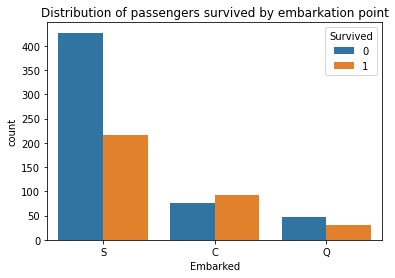

In [37]:
sns.countplot(hue="Survived", x="Embarked", data=data)
plt.title('Distribution of passengers survived by embarkation point');

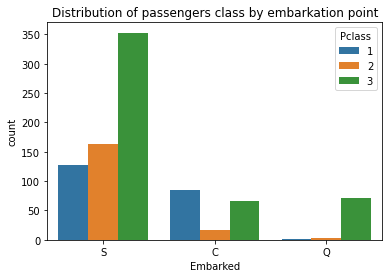

In [38]:
sns.countplot(hue="Pclass", x="Embarked", data=data)
plt.title('Distribution of passengers class by embarkation point');

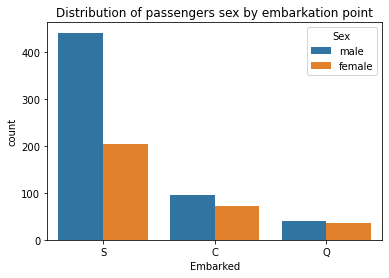

In [39]:
sns.countplot(hue="Sex", x="Embarked", data=data)
plt.title('Distribution of passengers sex by embarkation point');

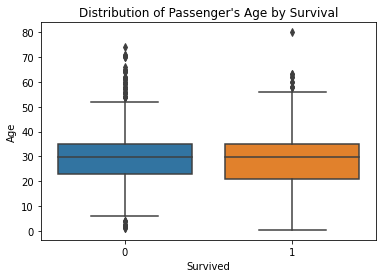

In [41]:
sns.boxplot(x="Survived",y="Age",data=data);
plt.xlabel("Survived")
plt.ylabel("Age")
plt.title("Distribution of Passenger's Age by Survival");

In [88]:
# Explore Relationships between Numerical Features

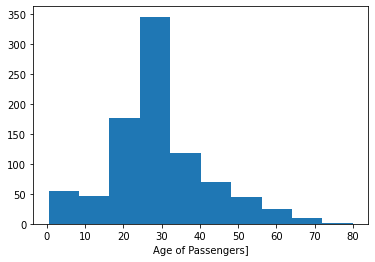

In [42]:
plt.hist(data["Age"])
plt.xlabel("Age of Passengers]");

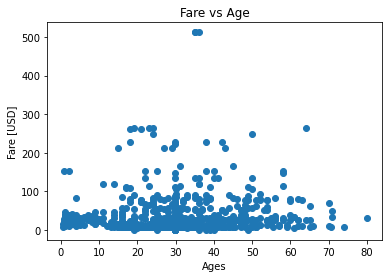

In [43]:
plt.scatter(x=data["Age"],y=data["Fare"])
plt.xlabel("Ages")
plt.ylabel("Fare [USD]")
plt.title("Fare vs Age");

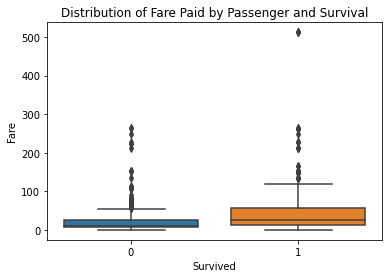

In [44]:
sns.boxplot(x="Survived",y="Fare",data=data);
plt.xlabel("Survived")
plt.ylabel("Fare")
plt.title("Distribution of Fare Paid by Passenger and Survival");

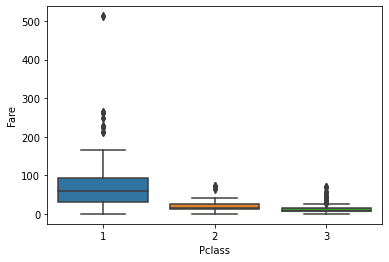

In [45]:
sns.boxplot(x="Pclass",y="Fare",data=data);

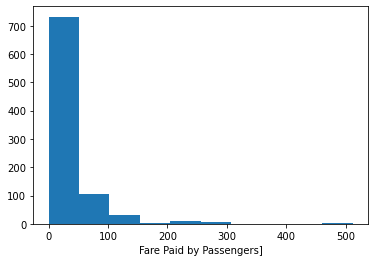

In [46]:
plt.hist(data["Fare"])
plt.xlabel("Fare Paid by Passengers]");

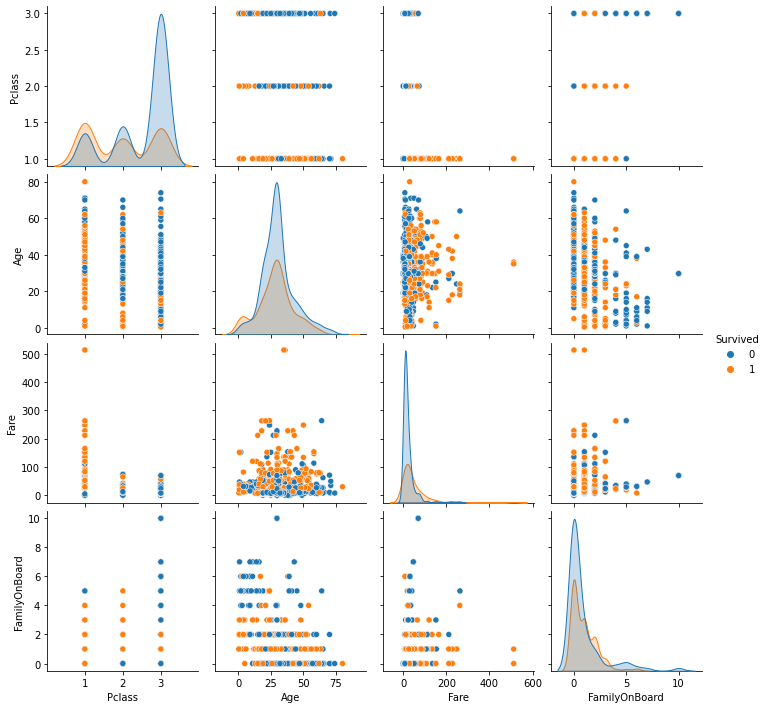

In [47]:
sns.pairplot(data, hue = 'Survived') 
plt.show()

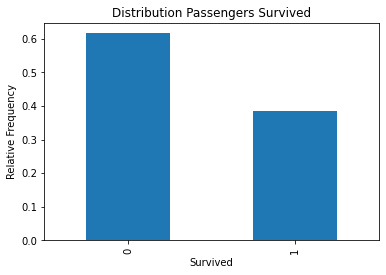

In [48]:
data["Survived"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Survived", ylabel="Relative Frequency", title="Distribution Passengers Survived"
);

### Instantiate PyCaret to Build Classification Model

In [50]:
class_space = setup(data = data, target = 'Survived', train_size = 0.8,normalize = True, session_id = 2000, remove_outliers = True, outliers_threshold = 0.05)

,Description,Value
0,session_id,2000
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(891, 8)"
5,Missing Values,True
6,Numeric Features,2
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [51]:
get_config("X").head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,FamilyOnBoard_0,...,FamilyOnBoard_3,FamilyOnBoard_4,FamilyOnBoard_5,FamilyOnBoard_6,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rev.
0,-0.568649,-0.497017,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.639419,0.753920,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.266632,-0.483830,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.412906,0.398696,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.412906,-0.481388,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [52]:
compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8416,0.8808,0.7585,0.8262,0.7858,0.6609,0.6678,0.0330
catboost,CatBoost Classifier,0.8357,0.8794,0.7278,0.8374,0.7712,0.6447,0.6552,0.3850
lr,Logistic Regression,0.8284,0.8733,0.7510,0.8034,0.7697,0.6337,0.6412,0.5010
knn,K Neighbors Classifier,0.8267,0.8644,0.7276,0.8185,0.7606,0.6267,0.6374,0.0090
ridge,Ridge Classifier,0.8254,0.0000,0.7473,0.7994,0.7657,0.6274,0.6351,0.0030
lda,Linear Discriminant Analysis,0.8210,0.8747,0.7436,0.7892,0.7596,0.6179,0.6247,0.0060
xgboost,Extreme Gradient Boosting,0.8179,0.8537,0.7430,0.7875,0.7596,0.6135,0.6192,0.0730
lightgbm,Light Gradient Boosting Machine,0.8149,0.8603,0.7353,0.7849,0.7530,0.6059,0.6129,0.1420
rf,Random Forest Classifier,0.8105,0.8570,0.7319,0.7756,0.7480,0.5969,0.6029,0.0580
ada,Ada Boost Classifier,0.8063,0.8567,0.7584,0.7539,0.7481,0.5914,0.6003,0.0350


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2000, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [53]:
model_gbc = create_model('gbc', verbose = False)

params = {'n_estimators': np.arange(100, 1000, 100),
        'max_depth': np.arange(1, 10),
        'learning_rate': np.arange(0.1, 2, 0.1),
        'min_samples_leaf': np.arange(1, 100, 10),
        'max_features': np.arange(0.1,1, 0.1)
        }

tuned_model = tune_model(model_gbc, optimize = 'Accuracy', fold = 10,
            tuner_verbose = False, search_library = 'scikit-optimize',
            custom_grid = params, n_iter = 50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8971,0.8934,0.8519,0.8846,0.8679,0.7836,0.7840
1,0.9118,0.9409,0.7692,1.0000,0.8696,0.8046,0.8204
2,0.8824,0.9373,0.8077,0.8750,0.8400,0.7472,0.7487
3,0.8235,0.8352,0.6154,0.8889,0.7273,0.6031,0.6254
4,0.8824,0.8901,0.8462,0.8462,0.8462,0.7509,0.7509
5,0.8088,0.8452,0.6923,0.7826,0.7347,0.5861,0.5888
6,0.7612,0.8143,0.6154,0.7273,0.6667,0.4826,0.4867
7,0.8657,0.8555,0.6538,1.0000,0.7907,0.6980,0.7322
8,0.8507,0.9301,0.8846,0.7667,0.8214,0.6943,0.6996
9,0.8060,0.8415,0.7692,0.7407,0.7547,0.5943,0.5946


In [55]:
model = finalize_model(tuned_model)

### Make Predictions

In [56]:
test = wrangle("test.csv")

In [57]:
pred_test = predict_model(model,data=test)
pred_test[:5]

,PassengerId,Pclass,Sex,Age,Fare,Embarked,FamilyOnBoard,Title,Label,Score
0,892,3,male,34.5,7.8292,Q,0,Mr.,0,0.9306
1,893,3,female,47.0,7.0000,S,1,Mrs.,0,0.8167
2,894,2,male,62.0,9.6875,Q,0,Mr.,0,0.9577
3,895,3,male,27.0,8.6625,S,0,Mr.,0,0.7352
4,896,3,female,22.0,12.2875,S,2,Mrs.,1,0.6835


In [58]:
submission_final = pred_test[["PassengerId","Label"]]
print(submission_final.shape)
submission_final.head()

(418, 2)


,PassengerId,Label
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [59]:
submission_final = submission_final.rename(columns = {"Label":"Survived"})

In [60]:
submission_final.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [61]:
submission_final.to_csv("submission.csv", index=False)

In [62]:
model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.30000000000000004, loss='deviance',
                           max_depth=7, max_features=0.4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=81, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2000, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Model Evaluation

In [87]:
plot_model(model,"parameter")

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.30000000000000004
loss,deviance
max_depth,7
max_features,0.4
max_leaf_nodes,None
min_impurity_decrease,0.0
min_impurity_split,None


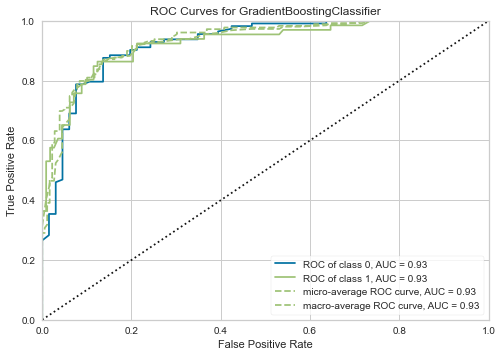

In [64]:
plot_model(model)

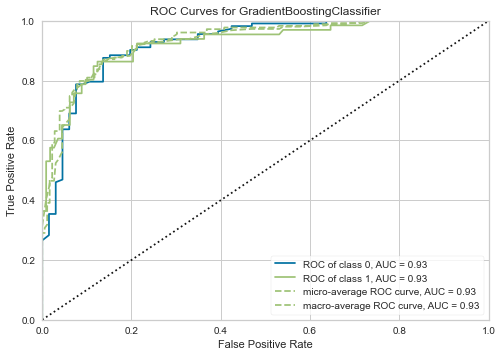

In [65]:
plot_model(model,"auc")

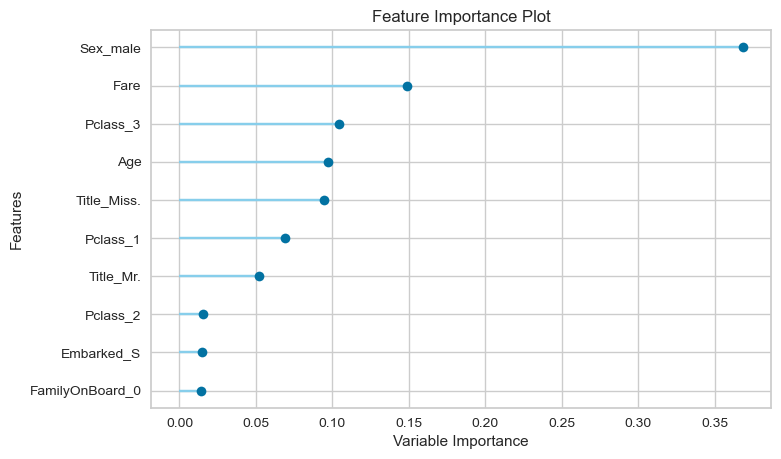

In [66]:
plot_model(model,"feature")

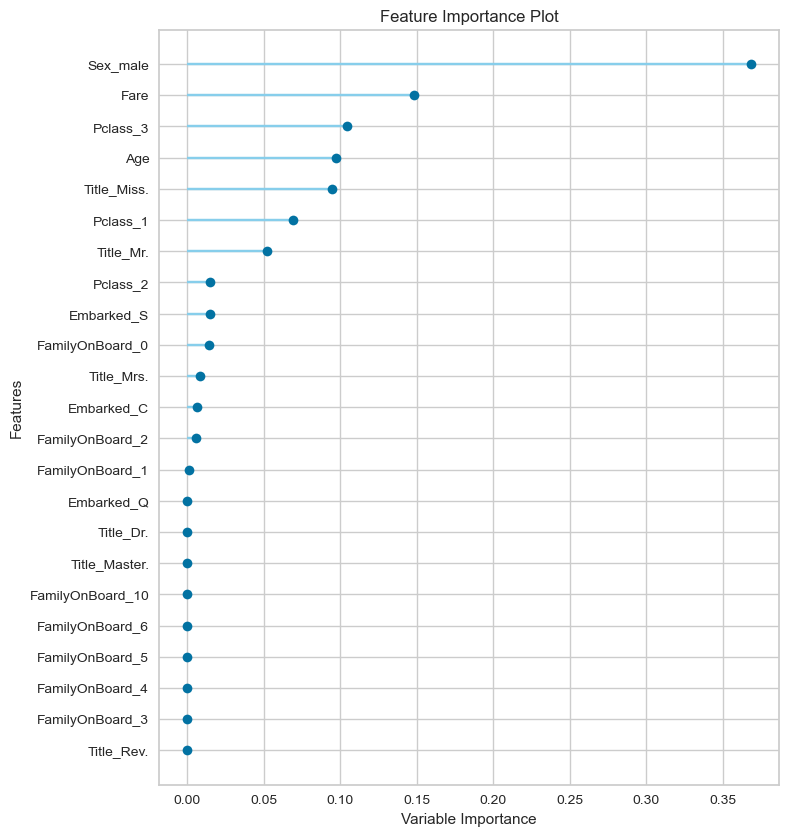

In [67]:
plot_model(model,"feature_all")

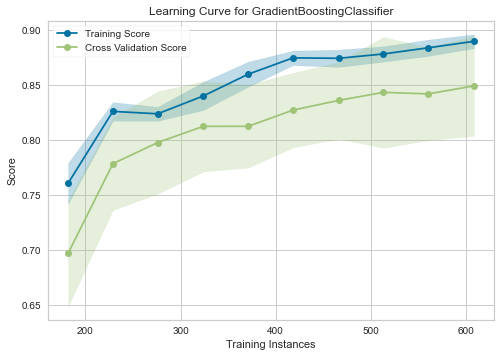

In [68]:
plot_model(model,"learning")

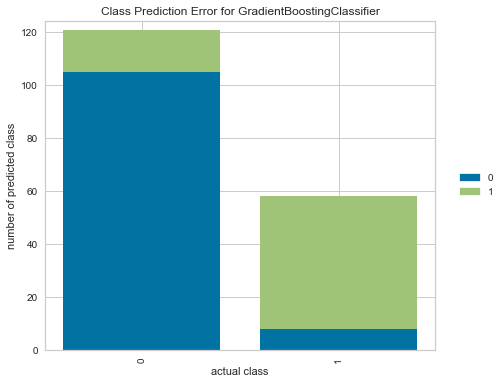

In [69]:
plot_model(model,"error")

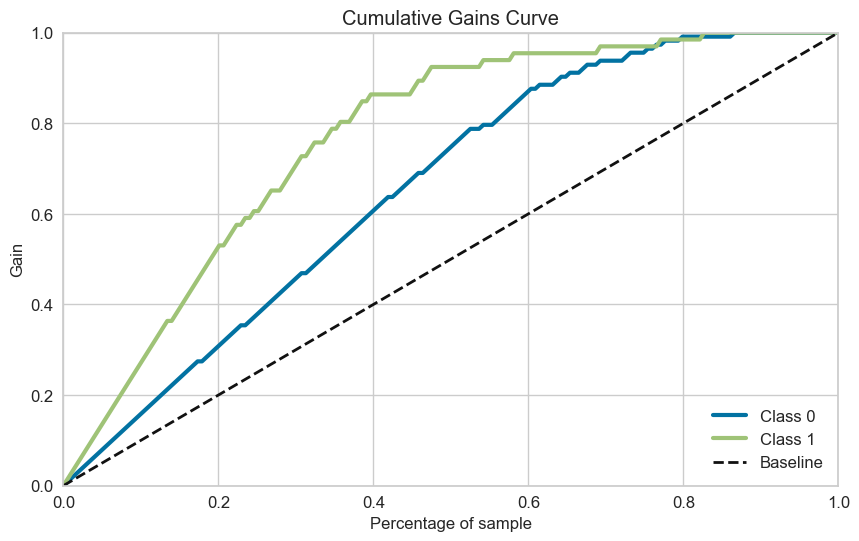

In [70]:
plot_model(model,"gain")

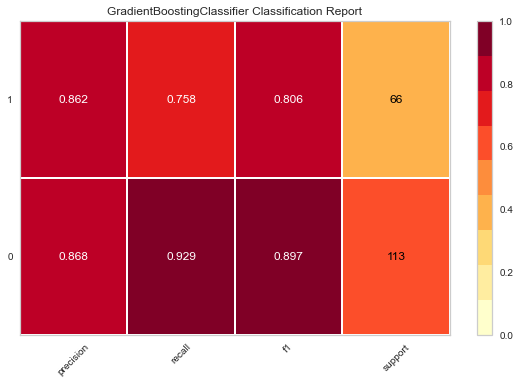

In [71]:
plot_model(model,"class_report")

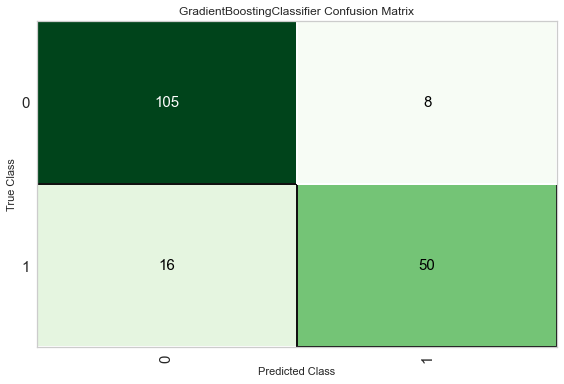

In [72]:
plot_model(model,"confusion_matrix")

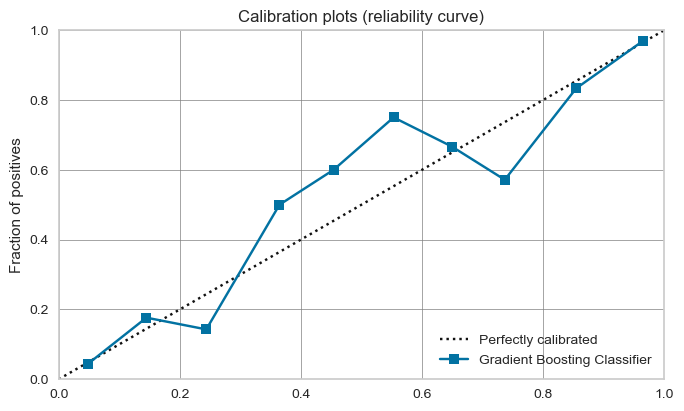

In [73]:
plot_model(model,"calibration")

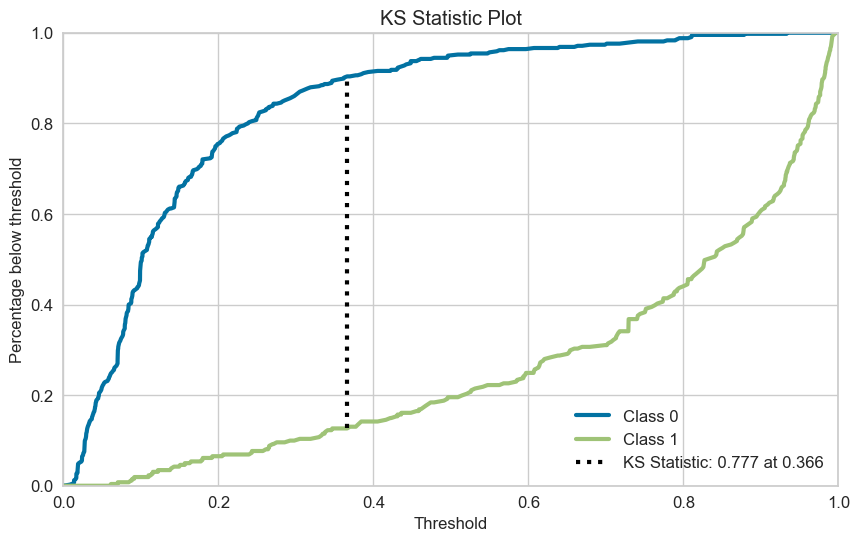

In [74]:
plot_model(model,"ks")